## Récupération et préparation des données


In [ ]:
from typing import List, Dict
import os
import re
import numpy as np
import pandas as pd
from fredapi import Fred
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from skfin.dataloaders.cache import CacheManager

ModuleNotFoundError: No module named 'skfin'

In [ ]:
# Param
FRED_API_KEY = os.getenv("FRED_API_KEY", "2d98c6caa7753b549869a87c5636fea0").strip()
# --- Fenêtre temporelle ---
DATE_START = pd.Timestamp("1982-01-01")
# Septembre 2025 inclus → on prend le dernier jour de mois
DATE_END = (pd.Timestamp("2025-08-01") + pd.offsets.MonthEnd(1))

date_start_str = DATE_START.strftime("%Y-%m-%d")
date_end_str   = DATE_END.strftime("%Y-%m-%d")

def _is_valid_fred_key(key: str) -> bool:
    return bool(re.fullmatch(r"[a-z0-9]{32}", key))

if not _is_valid_fred_key(FRED_API_KEY):
    raise ValueError(
        "FRED_API_KEY invalide: il faut exactement 32 caractères alphanumériques en minuscules. "
        f"Reçu: '{FRED_API_KEY}' (len={len(FRED_API_KEY)}). "
        "Corrige la clé (souvent un espace en trop)."
    )

series_ids = [
    "FEDFUNDS",
    "DGS1","DGS2","DGS5","DGS7","DGS10","DGS3MO",
    "T10Y2Y","T10Y3M",
    "NFCI","M2SL","CPIAUCSL","UNRATE",
    "INDPRO","MICH","PPIACO","CPIENGSL","BUSLOANS",
    "MPRIME","CPILFESL","TCU","UMCSENT", "NASDAQCOM"
]

fred = Fred(api_key=FRED_API_KEY)

# fonction qui trouve le dernier point non-NaN dans le mois
def last_valid_in_bucket(s: pd.Series):
    s = s.dropna()
    return s.iloc[-1] if not s.empty else np.nan

# détecter la fréquence officielle FRED
meta_rows = []
for sid in series_ids:
    try:
        info = fred.get_series_info(sid)
        freq = str(info.get("frequency", "")).strip()
        meta_rows.append({"series_id": sid, "frequency": freq})
    except Exception as e:
        # Si la métadonnée échoue, on traite par défaut comme haute fréquence
        meta_rows.append({"series_id": sid, "frequency": "UNKNOWN", "error": repr(e)})

meta = pd.DataFrame(meta_rows)
is_monthly = meta["frequency"].str.lower().str.startswith("monthly")
monthly_ids: List[str] = meta.loc[is_monthly, "series_id"].tolist()
hi_freq_ids: List[str] = meta.loc[~is_monthly, "series_id"].tolist()

# --- Étape 2 : télécharger et construire les deux DataFrame ---
# 2a) Mensuel natif
monthly_series: Dict[str, pd.Series] = {}
for sid in monthly_ids:
    try:
        s = fred.get_series(sid,
                            observation_start=date_start_str,
                            observation_end=date_end_str)
        s.index = pd.to_datetime(s.index)
        # Déjà mensuel → on s’aligne en fin de mois et on filtre par sécurité
        s = s.resample("M").last().loc[DATE_START:DATE_END]
        monthly_series[sid] = s.rename(sid)
    except Exception as e:
        print(f"[WARN] {sid}: {e}")

df_monthly_native = (
    pd.concat(monthly_series.values(), axis=1).sort_index()
    if monthly_series else pd.DataFrame()
)

# --- Étape 2b : séries haute fréquence → EOM (avec fenêtre) ---
hi_freq_series: Dict[str, pd.Series] = {}
for sid in hi_freq_ids:
    try:
        s = fred.get_series(sid,
                            observation_start=date_start_str,
                            observation_end=date_end_str)
        s.index = pd.to_datetime(s.index)
        # Agrégation fin de mois via "dernier point valide du mois"
        s_eom = s.resample("M").apply(last_valid_in_bucket).loc[DATE_START:DATE_END]
        hi_freq_series[sid] = s_eom.rename(sid)
    except Exception as e:
        print(f"[WARN] {sid}: {e}")

df_monthly_eom_from_highfreq = (
    pd.concat(hi_freq_series.values(), axis=1).sort_index()
    if hi_freq_series else pd.DataFrame()
)

# --- Fusion + filtre final de sécurité ---
fred_all = pd.concat(
    [df_monthly_native, df_monthly_eom_from_highfreq], axis=1
).sort_index().loc[DATE_START:DATE_END]


C:\Users\user\AppData\Local\Temp\ipykernel_62436\66021771.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.resample("M").last().loc[DATE_START:DATE_END]
C:\Users\user\AppData\Local\Temp\ipykernel_62436\66021771.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.resample("M").last().loc[DATE_START:DATE_END]
C:\Users\user\AppData\Local\Temp\ipykernel_62436\66021771.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.resample("M").last().loc[DATE_START:DATE_END]
C:\Users\user\AppData\Local\Temp\ipykernel_62436\66021771.py:63: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = s.resample("M").last().loc[DATE_START:DATE_END]
C:\Users\user\AppData\Local\Temp\ipykernel_62436\66021771.py:63: FutureWarning: 'M' is deprecated and will be removed in a futur

In [11]:
print(fred_all.head(5))
print(fred_all.tail(5))

            FEDFUNDS    M2SL  CPIAUCSL  UNRATE   INDPRO  MICH  PPIACO  \
1982-01-31     13.22  1770.4      94.4     8.6  48.7877   5.1    99.7   
1982-02-28     14.78  1774.5      94.7     8.9  49.7839   5.2    99.8   
1982-03-31     14.68  1786.5      94.7     9.0  49.4477   4.2    99.6   
1982-04-30     14.94  1803.9      95.0     9.3  48.9913   4.7    99.6   
1982-05-31     14.45  1815.4      95.9     9.4  48.6669   3.5    99.8   

            CPIENGSL  BUSLOANS  MPRIME  ...   DGS1   DGS2   DGS5   DGS7  \
1982-01-31     100.6  354.8455   15.75  ...  14.04  14.24  14.24  14.23   
1982-02-28      98.0  360.7137   16.56  ...  14.27  14.44  14.12  14.08   
1982-03-31      96.6  363.9746   16.50  ...  14.30  14.52  14.39  14.37   
1982-04-30      94.2  371.0565   16.50  ...  13.67  13.99  13.90  13.88   
1982-05-31      95.7  375.9823   16.50  ...  12.93  13.62  13.76  13.86   

            DGS10  DGS3MO  T10Y2Y  T10Y3M     NFCI  NASDAQCOM  
1982-01-31  14.14   13.08   -0.10    1.06  1.8

In [ ]:
CACHE_DIR = Path("data")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

cm = CacheManager(cache_dir=CACHE_DIR)

FILENAME = CACHE_DIR / "FRED_ALL.parquet"

# Sauvegarde correcte des deux DataFrames
cm.save_to_cache(fred_all, FILENAME)

Shape : (524, 23)

Aperçu :


,FEDFUNDS,M2SL,CPIAUCSL,UNRATE,INDPRO,MICH,PPIACO,CPIENGSL,BUSLOANS,MPRIME,...,DGS1,DGS2,DGS5,DGS7,DGS10,DGS3MO,T10Y2Y,T10Y3M,NFCI,NASDAQCOM
2025-04-30,4.33,21770.5,320.321,4.2,103.6224,6.5,258.392,278.118,2671.6721,7.5,...,3.85,3.60,3.72,3.93,4.17,4.31,0.57,-0.14,-0.39536,17446.34
2025-05-31,4.33,21827.4,320.580,4.2,103.6570,6.6,258.642,275.406,2680.2957,7.5,...,4.11,3.89,3.96,4.18,4.41,4.36,0.52,0.05,-0.46917,19113.77
2025-06-30,4.33,21942.4,321.500,4.1,104.2115,5.0,260.690,278.012,2687.2054,7.5,...,3.96,3.72,3.79,3.98,4.24,4.41,0.52,-0.17,-0.49931,20369.73
2025-07-31,4.33,22028.8,322.132,4.2,103.8194,4.5,262.562,275.044,2674.3234,7.5,...,4.10,3.94,3.96,4.14,4.37,4.41,0.43,-0.04,-0.52362,21122.45
2025-08-31,4.33,22108.4,323.364,4.3,103.9203,4.8,262.443,276.936,2684.6980,7.5,...,3.83,3.59,3.68,3.92,4.23,4.23,0.64,0.00,-0.53395,21455.55



Info générale :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 524 entries, 1982-01-31 to 2025-08-31
Freq: ME
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FEDFUNDS   524 non-null    float64
 1   M2SL       524 non-null    float64
 2   CPIAUCSL   524 non-null    float64
 3   UNRATE     524 non-null    float64
 4   INDPRO     524 non-null    float64
 5   MICH       524 non-null    float64
 6   PPIACO     524 non-null    float64
 7   CPIENGSL   524 non-null    float64
 8   BUSLOANS   524 non-null    float64
 9   MPRIME     524 non-null    float64
 10  CPILFESL   524 non-null    float64
 11  TCU        524 non-null    float64
 12  UMCSENT    524 non-null    float64
 13  DGS1       524 non-null    float64
 14  DGS2       524 non-null    float64
 15  DGS5       524 non-null    float64
 16  DGS7       524 non-null    float64
 17  DGS10      524 non-null    float64
 18  DGS3MO     524 non-null    float64
 19  T10Y2

,count,mean,std,min,25%,50%,75%,max
FEDFUNDS,524.0,3.944561,3.229512,0.05000,0.977500,4.08000,5.805000,14.94000
M2SL,524.0,8138.158206,5958.676647,1770.40000,3413.800000,6077.60000,11521.250000,22108.40000
CPIAUCSL,524.0,190.859790,60.173280,94.40000,142.250000,185.05000,236.580500,323.36400
UNRATE,524.0,5.970802,1.825936,3.40000,4.600000,5.60000,7.100000,14.80000
INDPRO,524.0,83.969242,18.096866,46.87130,64.335625,91.09770,99.451750,104.21150
MICH,524.0,3.176908,0.728825,0.40000,2.800000,3.00000,3.300000,6.60000
PPIACO,524.0,158.638338,47.920488,99.30000,118.675000,139.75000,197.225000,280.25100
CPIENGSL,524.0,164.705679,65.772861,82.10000,103.100000,141.85000,217.013250,332.28100
BUSLOANS,524.0,1263.713649,741.719170,354.84550,630.095375,1015.45790,1727.003725,3035.79770
MPRIME,524.0,6.741832,2.870772,3.25000,4.000000,7.07500,8.500000,16.56000



Nombre de lignes dupliquées : 0

Valeurs manquantes par colonne :


Series([], dtype: int64)


Pourcentage de valeurs manquantes :


FEDFUNDS     0.0
M2SL         0.0
CPIAUCSL     0.0
UNRATE       0.0
INDPRO       0.0
MICH         0.0
PPIACO       0.0
CPIENGSL     0.0
BUSLOANS     0.0
MPRIME       0.0
CPILFESL     0.0
TCU          0.0
UMCSENT      0.0
DGS1         0.0
DGS2         0.0
DGS5         0.0
DGS7         0.0
DGS10        0.0
DGS3MO       0.0
T10Y2Y       0.0
T10Y3M       0.0
NFCI         0.0
NASDAQCOM    0.0
dtype: float64

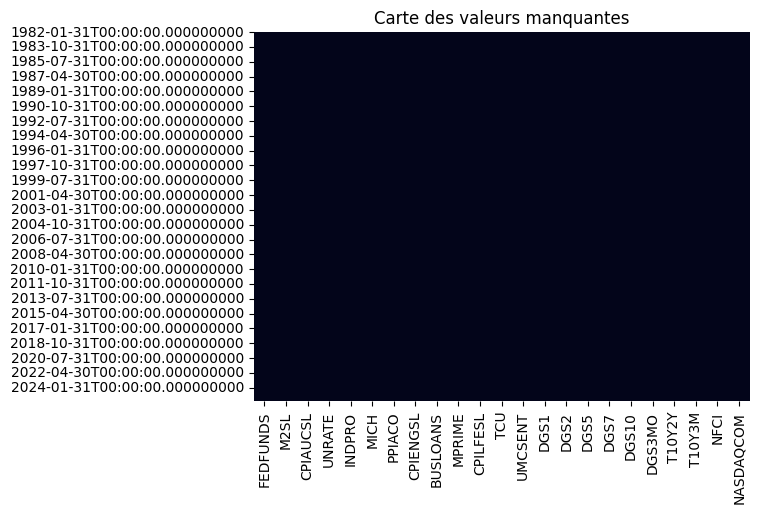


Types de données :
FEDFUNDS     float64
M2SL         float64
CPIAUCSL     float64
UNRATE       float64
INDPRO       float64
MICH         float64
PPIACO       float64
CPIENGSL     float64
BUSLOANS     float64
MPRIME       float64
CPILFESL     float64
TCU          float64
UMCSENT      float64
DGS1         float64
DGS2         float64
DGS5         float64
DGS7         float64
DGS10        float64
DGS3MO       float64
T10Y2Y       float64
T10Y3M       float64
NFCI         float64
NASDAQCOM    float64
dtype: object

Index temporel détecté 
Fréquence estimée : ME


C:\Users\user\AppData\Local\Temp\ipykernel_62436\3207853353.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  fred_all = fred_all.apply(pd.to_numeric, errors='ignore')


In [12]:
# Inspection initiale
print("Shape :", fred_all.shape)
print("\nAperçu :")
display(fred_all.tail())
 
print("\nInfo générale :")
fred_all.info()
 
print("\nStatistiques descriptives :")
display(fred_all.describe().T)
 
# Vérification des doublons
n_duplicates = fred_all.duplicated().sum()
print(f"\nNombre de lignes dupliquées : {n_duplicates}")
 
if n_duplicates > 0:
    fred_all = fred_all.drop_duplicates()
    print("Doublons supprimés.")
 
# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = fred_all.isna().sum()
display(missing[missing > 0])
 
# % de NaN
print("\nPourcentage de valeurs manquantes :")
display((fred_all.isna().mean() * 100).sort_values(ascending=False))
 
# plt.figure(figsize=(10,4))
sns.heatmap(fred_all.isna(), cbar=False)
plt.title("Carte des valeurs manquantes")
plt.show()
 
 
# Vérification des types
print("\nTypes de données :")
print(fred_all.dtypes)
 
# Conversion automatique si certaines colonnes devraient être numériques
fred_all = fred_all.apply(pd.to_numeric, errors='ignore')
 
# Vérification d’index temporel
if isinstance(fred_all.index, pd.DatetimeIndex):
    print("\nIndex temporel détecté ")
    print(f"Fréquence estimée : {pd.infer_freq(fred_all.index)}")
else:
    print("\ Pas d'index temporel, vérifie la colonne 'date' ou équivalent.")

In [17]:
data = pd.DataFrame(index=fred_all.index)

# spread FEDFUNDS - DGS3MO (niveau + diffs)
data["FEDFUNDS_minus_DGS3MO_level"] = fred_all["FEDFUNDS"] - fred_all["DGS3MO"]
data["FEDFUNDS_minus_DGS3MO_diff_1m"] = data["FEDFUNDS_minus_DGS3MO_level"] - data["FEDFUNDS_minus_DGS3MO_level"].shift(1)
data["FEDFUNDS_minus_DGS3MO_diff_12m"] = data["FEDFUNDS_minus_DGS3MO_level"] - data["FEDFUNDS_minus_DGS3MO_level"].shift(12)

# Groupes de variables
log_and_shift = [
    "M2SL","CPIAUCSL","CPILFESL","CPIENGSL",
    "INDPRO","PPIACO","BUSLOANS"
]

shift_only = [
    "UNRATE","TCU","UMCSENT","MICH"
]

no_log_no_shift = [  # taux, spreads, marché (SANS DGS3MO puisque supprimé)
    "FEDFUNDS",
    "DGS1","DGS2","DGS5","DGS7","DGS10",
    "T10Y2Y","T10Y3M",
    "MPRIME",
    "NASDAQCOM"
]

# 1) log + diff + shift(1)
for col in log_and_shift:
    L = np.log(fred_all[col])
    data[f"{col}_level_log"] = L
    data[f"{col}_diff_1m"] = L - L.shift(1)
    data[f"{col}_diff_12m"] = L - L.shift(12)
    data[[f"{col}_level_log",f"{col}_diff_1m",f"{col}_diff_12m"]] = \
        data[[f"{col}_level_log",f"{col}_diff_1m",f"{col}_diff_12m"]].shift(1)

# 2) pas log mais shift(1)
for col in shift_only:
    data[f"{col}_level"] = fred_all[col]
    data[f"{col}_diff_1m"] = fred_all[col] - fred_all[col].shift(1)
    data[f"{col}_diff_12m"] = fred_all[col] - fred_all[col].shift(12)
    data[[f"{col}_level",f"{col}_diff_1m",f"{col}_diff_12m"]] = \
        data[[f"{col}_level",f"{col}_diff_1m",f"{col}_diff_12m"]].shift(1)

# 3) temps réel → pas de shift
for col in no_log_no_shift:
    data[f"{col}_level"] = fred_all[col]
    data[f"{col}_diff_1m"] = fred_all[col] - fred_all[col].shift(1)
    data[f"{col}_diff_12m"] = fred_all[col] - fred_all[col].shift(12)

print(data.head(5))
print(data.tail(5))


            FEDFUNDS_minus_DGS3MO_level  FEDFUNDS_minus_DGS3MO_diff_1m  \
1982-01-31                         0.14                            NaN   
1982-02-28                         1.78                           1.64   
1982-03-31                         0.69                          -1.09   
1982-04-30                         1.79                           1.10   
1982-05-31                         2.48                           0.69   

            FEDFUNDS_minus_DGS3MO_diff_12m  M2SL_level_log  M2SL_diff_1m  \
1982-01-31                             NaN             NaN           NaN   
1982-02-28                             NaN        7.478961           NaN   
1982-03-31                             NaN        7.481274      0.002313   
1982-04-30                             NaN        7.488014      0.006740   
1982-05-31                             NaN        7.497706      0.009693   

            M2SL_diff_12m  CPIAUCSL_level_log  CPIAUCSL_diff_1m  \
1982-01-31            NaN      